In [13]:
import sys
sys.path.insert(0, '..')

In [14]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)


# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior
from fitting import *
from plotting import *

import jax.tree_util as jtu

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [15]:
extra_bad = None
#extra_bad = np.isnan(np.zeros((64, 64)).at[35,60].set(np.nan))

#extra_bad = np.isnan(np.zeros((wid,wid))).at[wid//2-3:wid//2+3,:].set(np.nan)


In [16]:
wid = 64
oversample = 4

nwavels = 3#6
npoly=2#2

n_zernikes = 12

optics = NICMOSOptics(1024, wid, oversample, n_zernikes = n_zernikes)

detector = NICMOSDetector(oversample, wid)

ddir = "../data/MAST_2024-09-22T03_37_01.724Z/HST/"

# brown dwarf

files = [
    'n8yj53vfq_cal.fits'

]


# lhs 1846
ddir = "../data/MAST_2025-03-02T22_29_29.259Z/HST/"

files = ["n8ku01ffq_cal.fits", "n8ku01fgq_cal.fits"][:1]

ddir = "../data/MAST_2024-09-08T07_59_18.213Z/HST/"

files = [
    # F095N
    "n43ca5fjq_cal.fits",
    "n43ca5fkq_cal.fits",
    "n43ca5flq_cal.fits",
    "n43ca5fmq_cal.fits",
    #F190N
    "n43ca5feq_cal.fits",
    "n43ca5ffq_cal.fits",
    "n43ca5fgq_cal.fits",
    "n43ca5fhq_cal.fits",
    #F187N
    #"n43c03dnq_cal.fits",
    #"n43c03doq_cal.fits",
    #"n43c03dpq_cal.fits",
    #"n43c03drq_cal.fits",
    #F108N
    #"n43c03dsq_cal.fits",
    #"n43c03duq_cal.fits",
    ##"n43c03dvq_cal.fits",
    ##"n43c03dwq_cal.fits",
][-1:]
"""
# hyades

ddir = "../data/MAST_2024-09-26T22_53_13.719Z/HST/"

files = [
    "n8ry37p8q_cal.fits",
    "n8ry37p9q_cal.fits",

    #"n8ry13mqq_cal.fits",
    #"n8ry13mrq_cal.fits"
][:-1]


ddir = '../data/MAST_2025-03-06T11_35_52.340Z/HST/'

files = [
    #F110M
    'n4be02npq_cal.fits',
    'n4be02nsq_cal.fits',
    'n4be02nvq_cal.fits',
    'n4be02nyq_cal.fits',

    #F145M
    'n4be02nqq_cal.fits',
    'n4be02ntq_cal.fits',
    'n4be02nwq_cal.fits',
    'n4be02o0q_cal.fits',
]#[:1]#[-2:-1]
"""
#extra_bad = np.isnan(np.zeros((wid,wid))).at[wid//2-3:wid//2+3,:].set(np.nan)

exposures_single = [exposure_from_file(ddir + file, SinglePointPolySpectrumFit(nwavels), crop=wid, extra_bad=extra_bad) for file in files]

#exposures_binary = [exposure_from_file(ddir + file, BinaryPolySpectrumFit(nwavels), crop=wid, extra_bad=extra_bad) for file in files]

/var/folders/hv/659ls99s2sjd7m3dfr17k8cm0000gn/T/ipykernel_99270/44869847.py:84: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  exposures_single = [exposure_from_file(ddir + file, SinglePointPolySpectrumFit(nwavels), crop=wid, extra_bad=extra_bad) for file in files]


In [17]:
data = '../data/MAST_2024-09-27T00_15_31.056Z/HST/'

files = """
na2a12jmq_cal.fits
na2a12jnq_cal.fits
na2a12joq_cal.fits
na2a12jpq_cal.fits
na2a12jqq_cal.fits
na2a12jxq_cal.fits
na2a12jzq_cal.fits
na2a12k0q_cal.fits
na2a12k1q_cal.fits
na2a12k2q_cal.fits
na2a12k9q_cal.fits
na2a12kbq_cal.fits
na2a12kcq_cal.fits
na2a12kdq_cal.fits
na2a12keq_cal.fits
na2a12klq_cal.fits
na2a12knq_cal.fits
na2a12koq_cal.fits
na2a12kpq_cal.fits
na2a12kqq_cal.fits
na2a12kxq_cal.fits
na2a12kzq_cal.fits
na2a12l0q_cal.fits
na2a12l1q_cal.fits
na2a12l2q_cal.fits
na2a12lgq_cal.fits
na2a12liq_cal.fits
na2a12ljq_cal.fits
na2a12lkq_cal.fits
na2a12llq_cal.fits
na2a12lsq_cal.fits
na2a12luq_cal.fits
na2a12lvq_cal.fits
na2a12lwq_cal.fits
na2a12lxq_cal.fits
na2a12m4q_cal.fits
na2a12m6q_cal.fits
na2a12m7q_cal.fits
na2a12m8q_cal.fits
na2a12m9q_cal.fits
na2a12mgq_cal.fits
na2a12miq_cal.fits
na2a12mjq_cal.fits
na2a12mkq_cal.fits
na2a12mlq_cal.fits
na2a12msq_cal.fits
na2a12muq_cal.fits
na2a12mvq_cal.fits
na2a12mwq_cal.fits
na2a12mxq_cal.fits
na2a12n4q_cal.fits
na2a12n6q_cal.fits
na2a12n7q_cal.fits
na2a12n8q_cal.fits
na2a12n9q_cal.fits
""".split()

print(files)


#exposures_single = [exposure_from_file(data+f, SinglePointPolySpectrumFit(nwavels), crop=wid, extra_bad=extra_bad) for f in files][:10]

['na2a12jmq_cal.fits', 'na2a12jnq_cal.fits', 'na2a12joq_cal.fits', 'na2a12jpq_cal.fits', 'na2a12jqq_cal.fits', 'na2a12jxq_cal.fits', 'na2a12jzq_cal.fits', 'na2a12k0q_cal.fits', 'na2a12k1q_cal.fits', 'na2a12k2q_cal.fits', 'na2a12k9q_cal.fits', 'na2a12kbq_cal.fits', 'na2a12kcq_cal.fits', 'na2a12kdq_cal.fits', 'na2a12keq_cal.fits', 'na2a12klq_cal.fits', 'na2a12knq_cal.fits', 'na2a12koq_cal.fits', 'na2a12kpq_cal.fits', 'na2a12kqq_cal.fits', 'na2a12kxq_cal.fits', 'na2a12kzq_cal.fits', 'na2a12l0q_cal.fits', 'na2a12l1q_cal.fits', 'na2a12l2q_cal.fits', 'na2a12lgq_cal.fits', 'na2a12liq_cal.fits', 'na2a12ljq_cal.fits', 'na2a12lkq_cal.fits', 'na2a12llq_cal.fits', 'na2a12lsq_cal.fits', 'na2a12luq_cal.fits', 'na2a12lvq_cal.fits', 'na2a12lwq_cal.fits', 'na2a12lxq_cal.fits', 'na2a12m4q_cal.fits', 'na2a12m6q_cal.fits', 'na2a12m7q_cal.fits', 'na2a12m8q_cal.fits', 'na2a12m9q_cal.fits', 'na2a12mgq_cal.fits', 'na2a12miq_cal.fits', 'na2a12mjq_cal.fits', 'na2a12mkq_cal.fits', 'na2a12mlq_cal.fits', 'na2a12ms

In [18]:
for e in exposures_single:
    print(e.mjd)#*86400)
    print(e.target)
    print(e.filter)

50934.93448622
SAO179809-PSF
F190N


In [ ]:
params = {
    #"fluxes": {},
    "positions": {},
    "spectrum": {},
    "aberrations": {},

    #"rot": 0.,

    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.04297,

    "softening": 2.,#0.1,
    "bias": {},
    "jitter": {},
    #"displacement": 1.#1e5#{}
}

for exp in exposures_single:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.zeros(npoly).at[0].set(1)*np.log10(np.nansum(exp.data)/nwavels)
    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(n_zernikes)#np.asarray([0., 24.884588  , -25.489779  , -17.15699   , -21.790146  ,
    #      -4.592212  ,  -4.832893  ,  19.196083  ,   0.37983412,
    #       7.0756216 ,   0.30277824,  -6.330534])#np.zeros(n_zernikes)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.zeros(2)#-np.asarray([9.599048, 6.196583])
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. + 90. 
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])
    #params["displacement"][exp.fit.get_key(exp, "displacement")] = 1e6

    params["bias"][exp.fit.get_key(exp, "bias")] = 0.
    params["jitter"][exp.fit.get_key(exp, "jitter")] = 7/43*oversample


model_single = set_array(NICMOSModel(exposures_single, params, optics, detector))
#model_binary = set_array(NICMOSModel(exposures_binary, params, optics, detector))


params = ModelParams(params)

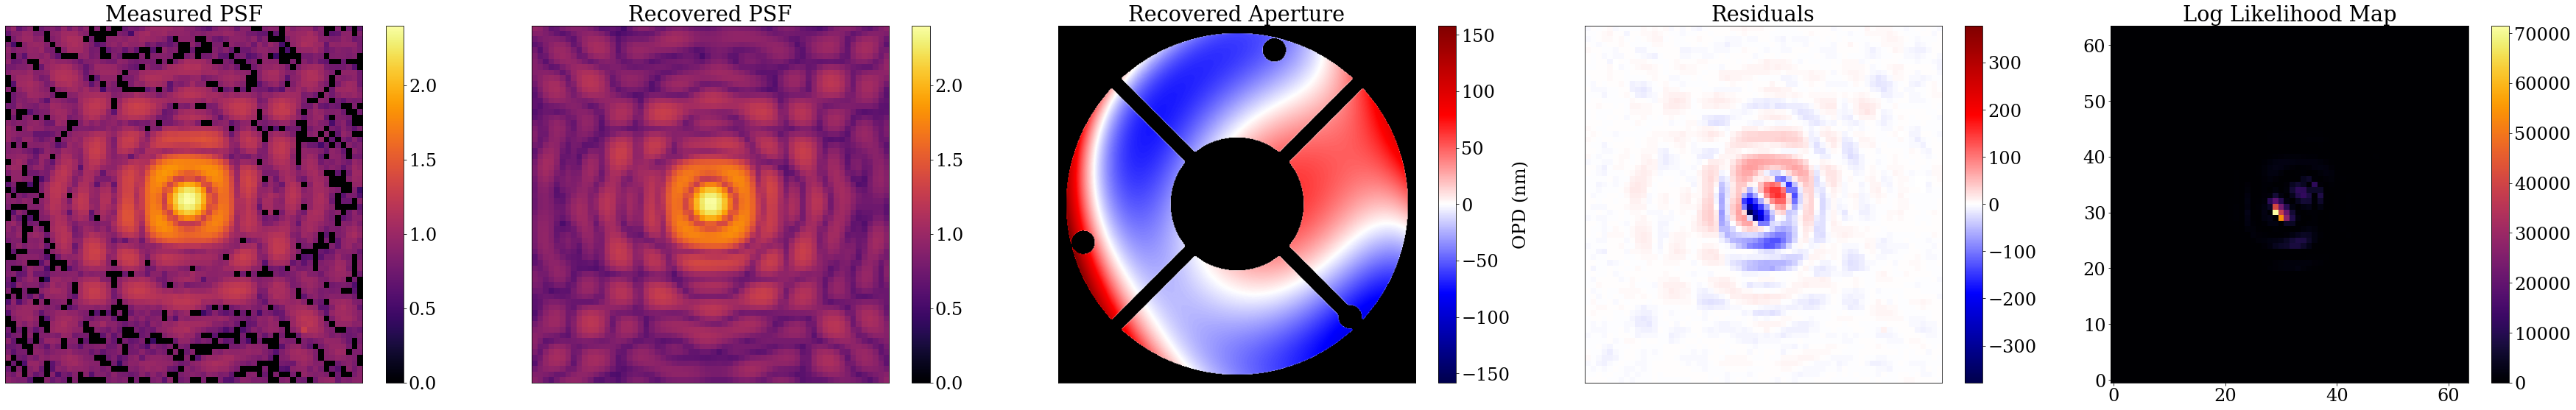

In [20]:
plot_comparison(model_single, params, exposures_single)

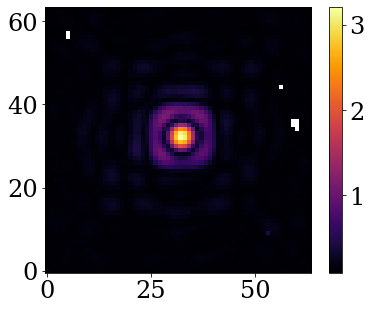

In [21]:
plt.imshow(exposures_single[0].err)
plt.colorbar()

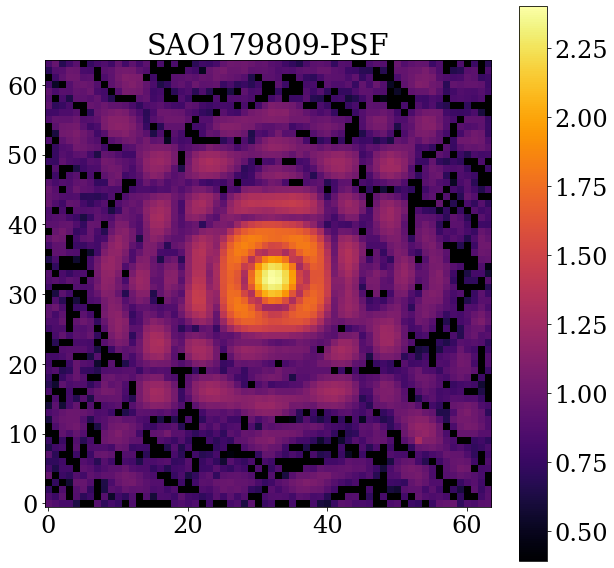

In [22]:
cmap = matplotlib.colormaps['inferno']
cmap.set_bad('k',1)
plt.figure(figsize=(10,10))
plt.imshow(exposures_single[0].data**0.125, cmap=cmap)
plt.title(exposures_single[0].target)
plt.colorbar()


In [23]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))

base_lbfgs = lambda vals: optax.lbfgs(vals)

optl = lambda lr, start, *schedule: base_lbfgs(scheduler(lr, start, *schedule))




def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 5e-2

things = {
    "positions": opt(g*5, 0),
    "spectrum": opt(g*8, 10),#, (20, 1.5)),
    "cold_mask_shift": opt(g*300, 30),
    "cold_mask_rot": opt(g*10, 100),
    "bias": opt(g*3, 20),
    #"aberrations": opt(g*0.15,300),#, (80, 2)),#, (150, g*0.2)),
    "aberrations": opt(g*0.2, 60)
    #"aberrations": opta(2, 50),
    #"aberrations": opta(2, 50),
    #"aberrations": optl(2,50),
    #"displacement": opt(g*30, 150),

    #"cold_mask_scale": opt(g*100, 250),
    #"cold_mask_shear": opt(g*100, 250),
    #"primary_scale": opt(g*100, 300),
    #"primary_shear": opt(g*100, 300),
}


groups = list(things.keys())

In [24]:
losses, models = optimise(params, model_single, exposures_single, things, 300)

Calculating Fishers


  0%|          | 0/1 [00:00<?, ?it/s]

ModelParams(
  params={
    'positions': {'n43ca5fhq': f32[2]},
    'spectrum': {'SAO179809-PSF_F190N': f32[2]},
    'aberrations': {'n43ca5fhq': f32[12]},
    'cold_mask_shift': {'50935': f32[2]},
    'cold_mask_rot': {'global': -45.0},
    'cold_mask_scale': {'F190N': f32[2]},
    'cold_mask_shear': {'F190N': f32[2]},
    'primary_scale': {'F190N': f32[2]},
    'primary_rot': {'F190N': 45.0},
    'primary_shear': {'F190N': f32[2]},
    'outer_radius': 1.146,
    'secondary_radius': 0.44639999999999996,
    'spider_width': 0.0924,
    'scale': 0.04297,
    'softening': 2.0,
    'bias': {'n43ca5fhq': 0.0},
    'jitter': {'n43ca5fhq': 0.6511627906976745}
  }
)
Fitting Model


  0%|          | 0/300 [00:00<?, ?it/s]

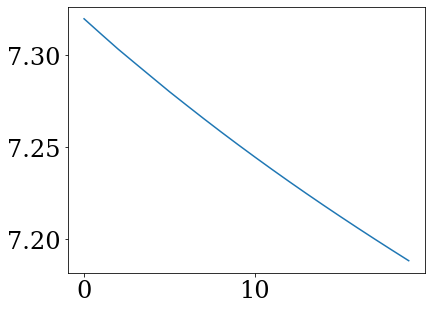

In [25]:
plt.plot(np.asarray(losses[-20:])/(len(exposures_single)*wid**2))

In [26]:
print(losses[0], losses[-1])

874793.56 29443.46


6


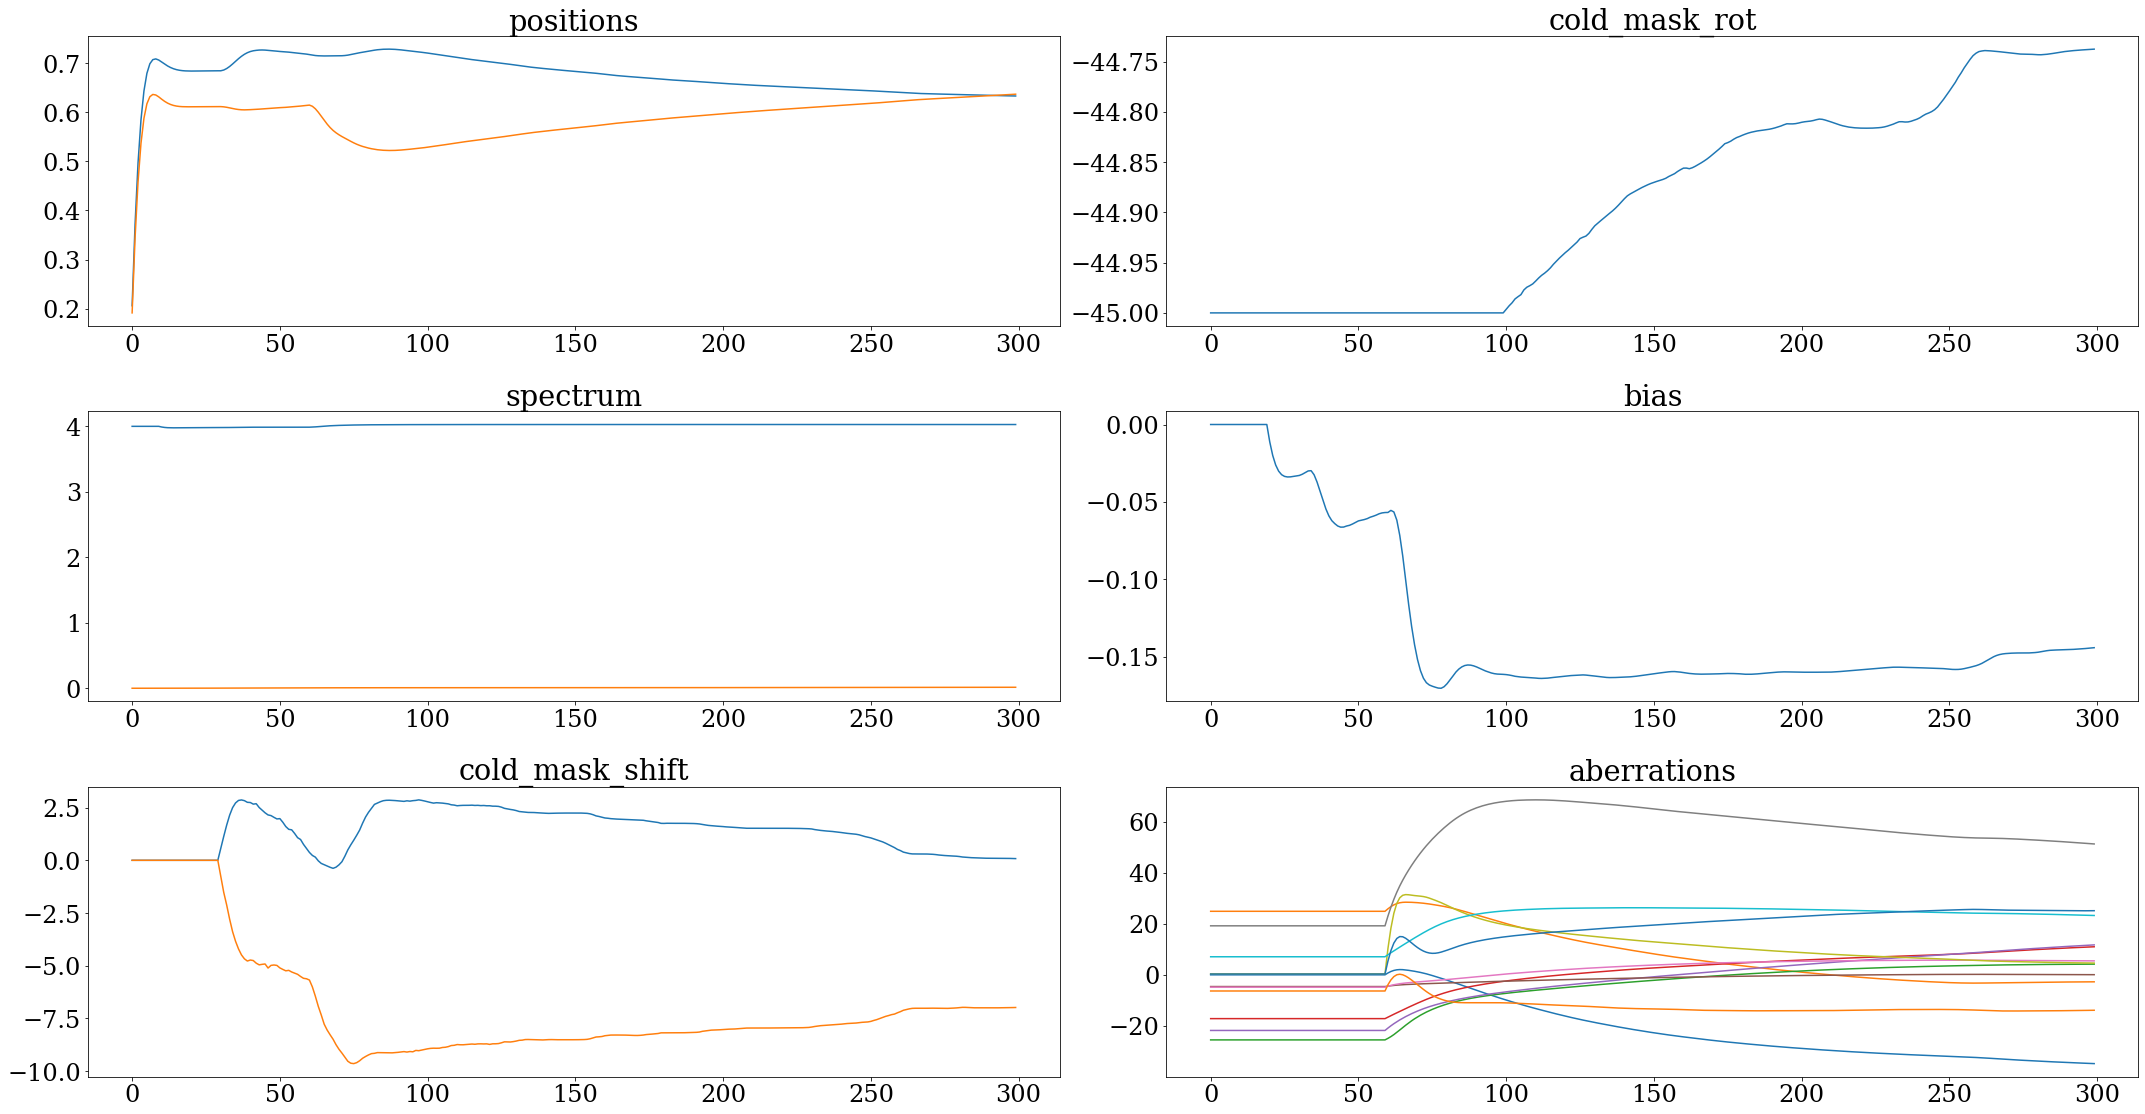

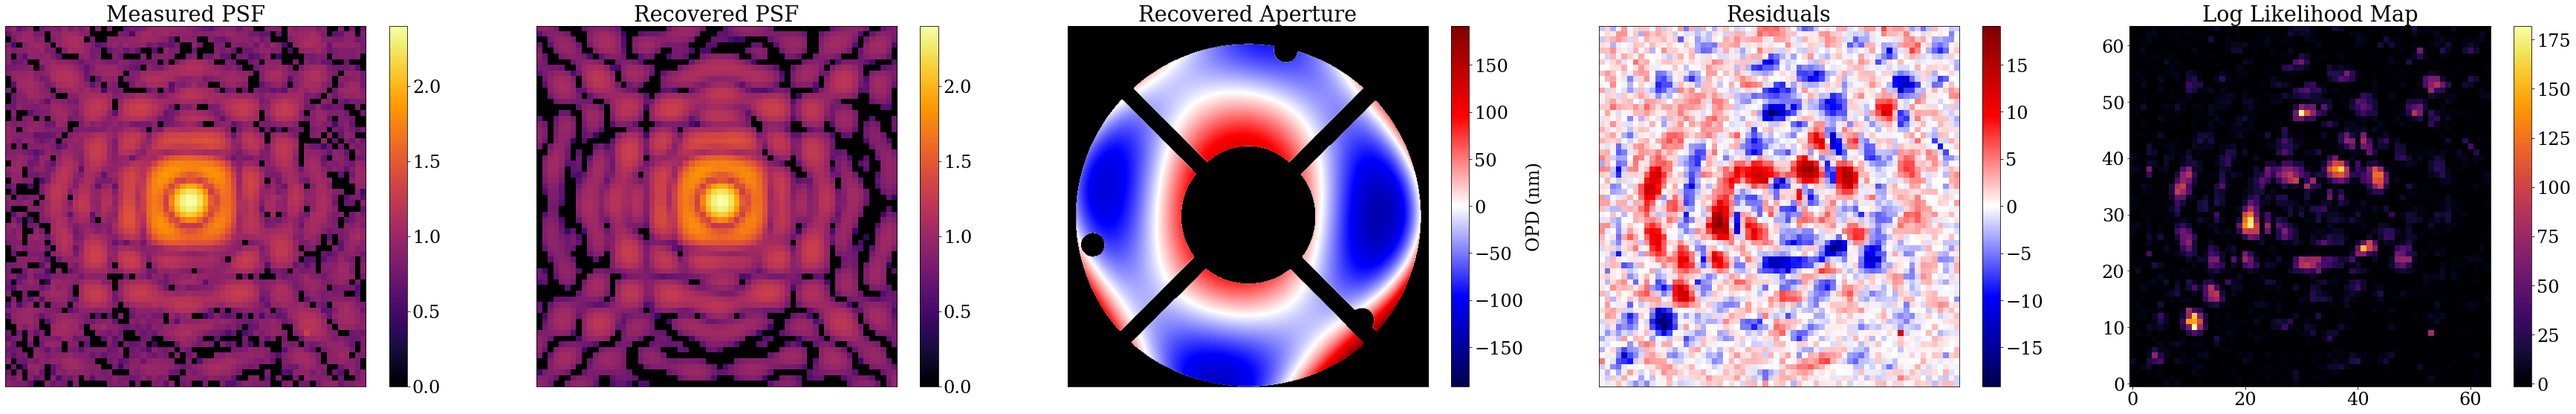

In [27]:
plot_params(models, groups, xw = 3)
plot_comparison(model_single, models[-1], exposures_single)

In [28]:
print(models[-1].params)

{'aberrations': {'n43ca5fhq': Array([-34.778378  ,  -2.738231  ,   4.191448  ,  10.987734  ,
        11.722178  ,   0.05602115,   5.4669685 ,  51.2608    ,
         4.602158  ,  23.243176  ,  25.119394  , -13.878716  ],      dtype=float32)}, 'bias': {'n43ca5fhq': Array(-0.14410712, dtype=float32)}, 'cold_mask_rot': {'global': Array(-44.737686, dtype=float32)}, 'cold_mask_shift': {'50935': Array([ 0.08075154, -6.9821315 ], dtype=float32)}, 'positions': {'n43ca5fhq': Array([0.63280296, 0.6364331 ], dtype=float32)}, 'spectrum': {'SAO179809-PSF_F190N': Array([4.029377  , 0.01492984], dtype=float32)}}


In [29]:
models[-1].inject(model_single)

NICMOSModel(
  params={
    'aberrations': {'n43ca5fhq': f32[12]},
    'bias': {'n43ca5fhq': f32[]},
    'cold_mask_rot': {'global': f32[]},
    'cold_mask_scale': {'F190N': f32[2]},
    'cold_mask_shear': {'F190N': f32[2]},
    'cold_mask_shift': {'50935': f32[2]},
    'jitter': {'n43ca5fhq': f32[]},
    'outer_radius': f32[],
    'positions': {'n43ca5fhq': f32[2]},
    'primary_rot': {'F190N': f32[]},
    'primary_scale': {'F190N': f32[2]},
    'primary_shear': {'F190N': f32[2]},
    'scale': f32[],
    'secondary_radius': f32[],
    'softening': f32[],
    'spectrum': {'SAO179809-PSF_F190N': f32[2]},
    'spider_width': f32[]
  },
  filters={'F190N': f32[83,2]},
  optics=NICMOSOptics(
    wf_npixels=1024,
    diameter=f32[],
    layers={
      'CompoundAperture':
      CompoundAperture(
        normalise=True,
        transformation=CoordTransform(
          translation=None, rotation=f32[], compression=None, shear=None
        ),
        apertures={
          'cold_mask':
         

In [30]:
fsh = calc_fishers(models[-1].inject(model_single), exposures_single, ["aberrations"], recalculate=True, save=False)


TypeError: calc_fishers() missing 1 required positional argument: 'fisher_fn'

In [ ]:
fsh

{'n8ry37p8q': {'aberrations': Array([[ 13.256942  ,  13.521341  ,  -5.3797503 ,  -2.918567  ,
            9.026647  ,  -6.9554114 ,   3.9423215 ,   9.836314  ,
           -7.907414  ,  -6.9364066 ,  -2.3607695 ,  -1.378787  ],
         [ 13.521132  ,  18.408028  ,  -2.9194837 ,   5.031714  ,
           -2.3781905 ,   1.0947808 ,  17.211847  ,  -2.1316876 ,
           -6.804498  ,   1.6939858 ,  -4.4753637 ,  -1.30014   ],
         [ -5.379681  ,  -2.9200506 ,  31.988798  ,  -1.5203192 ,
           -0.45664895, -16.643995  ,  -7.1655164 ,  -1.544157  ,
           -6.7426624 ,   8.277584  ,   6.7855797 ,  10.456741  ],
         [ -2.9185808 ,   5.0321403 ,  -1.52028   , 113.891335  ,
           16.81691   , -11.982259  , -26.879892  ,  35.479324  ,
          -31.100693  , -13.9164    ,  11.90669   ,  -4.084443  ],
         [  9.026873  ,  -2.378535  ,  -0.4567974 ,  16.817049  ,
          109.20379   ,  32.327824  ,  -0.4987429 , -26.84931   ,
          -14.729364  ,  13.389488  ,  -7.25

In [ ]:
defocuses = [x[0] for x in models[-1].params["aberrations"].values()]
errs = [1/x['defocus']/20 for x in fsh.values()]
mjds = [exp.mjd for exp in exposures_single]
mjds= [(x - mjds[0])*24*60 for x in mjds]


KeyError: 'defocus'

In [ ]:
fsh = calc_fishers(models[-1].inject(model_single), exposures_single, ["cold_mask_shift"], recalculate=True, save=False)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
fsh

{'n43ca5fjq': {'cold_mask_shift': Array([[390.8453 , 140.86757],
         [140.86752, 416.00952]], dtype=float32)},
 'n43ca5fkq': {'cold_mask_shift': Array([[152.32484, 105.43479],
         [105.43475, 345.59708]], dtype=float32)},
 'n43ca5flq': {'cold_mask_shift': Array([[345.77246 ,  55.504807],
         [ 55.50482 , 300.86816 ]], dtype=float32)},
 'n43ca5fmq': {'cold_mask_shift': Array([[1238.8579 ,   44.38602],
         [  44.38599, 1308.0029 ]], dtype=float32)},
 'n43ca5feq': {'cold_mask_shift': Array([[2689.8403 ,  561.36896],
         [ 561.3691 , 2995.826  ]], dtype=float32)},
 'n43ca5ffq': {'cold_mask_shift': Array([[2504.4548,  871.225 ],
         [ 871.225 , 2532.2686]], dtype=float32)},
 'n43ca5fgq': {'cold_mask_shift': Array([[  14.643265,  410.93805 ],
         [ 410.93787 , -500.36264 ]], dtype=float32)},
 'n43ca5fhq': {'cold_mask_shift': Array([[1289.0402 ,  509.19507],
         [ 509.19507, 1018.38055]], dtype=float32)}}

In [ ]:
plt.figure(figsize=(10,10))

wv, filt = calc_throughput("F170M", nwavels=nwavels)

#HD201592_F110M

#plt.plot(wavels, params.get("spectrum.U10764_F110W"))
plt.plot(wv, 10**(NonNormalisedClippedPolySpectrum(np.linspace(-1, 1, nwavels), models[-1].get("spectrum.LHS1846_F170M")).weights))#), yerr = spectrum_err)


KeyError: 'LHS1846_F170M'

<Figure size 720x720 with 0 Axes>

In [ ]:
bad = np.ones((wid, wid))

In [ ]:
for i in range(8):
    pst = posterior(models[-1].inject(model_single),exposures_single[0],return_im=True)
    idx = np.unravel_index(np.nanargmax(pst*bad), pst.shape)
    bad = bad.at[idx].set(np.nan)


In [ ]:
extra_bad = np.isnan(bad)

In [ ]:
idx

(Array(68, dtype=int32), Array(67, dtype=int32))

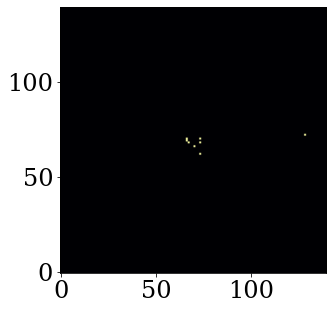

In [ ]:
plt.imshow(extra_bad)

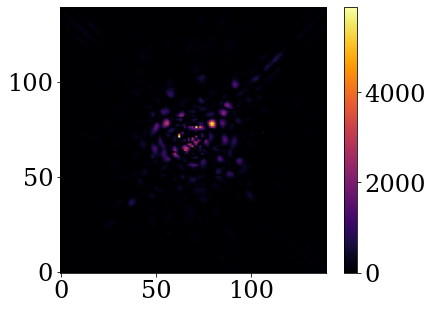

In [ ]:
plt.imshow(pst*(1-extra_bad))
plt.colorbar()

In [ ]:
jsp.stats.norm.logpdf(0,0,0.1)

Array(1.3836465, dtype=float32, weak_type=True)